# Land Cover Classification with DeepLabV3+

In [1]:
# Modules
import numpy as np
from matplotlib import pyplot
from skimage import color, data, exposure, feature, filters, io, morphology, segmentation, transform, util
import tensorflow as tf

import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import PIL
import os
from PIL import Image
import numpy as np
import sklearn
import keras
from PIL import Image
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import random 


In [2]:
import os
term_project_dir="/Users/pazma/Documents/BSE/spatial_data/term_project/"
os.chdir(term_project_dir)

In [3]:
# import custom-made functions
from helper_functions import *
from preprocess_and_stats import *

## Load the data

In [4]:
# get mask and sat paths from the train folder 
mask_train_files = sorted([f for f in os.listdir(term_project_dir + "data/land-train/") if re.match(r'.*mask\.png', f)])
sat_train_files = sorted([f for f in os.listdir(term_project_dir + "data/land-train/") if re.match(r'.*sat\.jpg', f)])
print(mask_train_files[:10])
print(sat_train_files[:10])

['100694_mask.png', '102122_mask.png', '10233_mask.png', '103665_mask.png', '103730_mask.png', '104113_mask.png', '10452_mask.png', '10901_mask.png', '111335_mask.png', '114433_mask.png']
['100694_sat.jpg', '102122_sat.jpg', '10233_sat.jpg', '103665_sat.jpg', '103730_sat.jpg', '104113_sat.jpg', '10452_sat.jpg', '10901_sat.jpg', '111335_sat.jpg', '114433_sat.jpg']


In [5]:
metadata_train=pd.DataFrame(mask_train_files,sat_train_files).reset_index()
metadata_train.columns=["sat", "mask"]

In [6]:
# class label dictionary
class_dict={"urban_land": [0, 255, 255],
           "agriculture_land": [255, 255, 0],
           "range_land": [255, 0, 255],
           "forest_land": [0, 255, 0],
           "water": [0, 0, 255],
           "barren_land": [255, 255, 255],
           "unknown": [0,0,0]}
class_dict.keys(), class_dict.values()

(dict_keys(['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']),
 dict_values([[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]))

In [7]:
# Get class names
class_names = list(class_dict.keys())
# Get class RGB values
class_rgb_values = list(class_dict.values())

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [8]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


## Build the model

In [9]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    """
    backbone: how can I implement to use another backbone? {'xception','mobilenetv2'}
    https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/model.py 
    
    """
    import tensorflow
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tensorflow.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)



In [10]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

IMAGE_SIZE=224
NUM_CLASSES=7

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Metal device set to: Apple M1


2022-04-01 20:01:31.327814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-01 20:01:31.327921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 concatenate (Concatenate)      (None, 14, 14, 1280  0           ['up_sampling2d[0][0]',          
                                )                                 'tf.nn.relu_1[0][0]',           
                                                                  'tf.nn.relu_2[0][0]',           
                                                                  'tf.nn.relu_3[0][0]',           
                                                                  'tf.nn.relu_4[0][0]']           
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 256)  327680      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 14, 14, 256)  1024       ['conv2d_5[0][0]']               
 rmalizati

In [11]:
BATCH_SIZE = 32 
PATH_TRAIN =term_project_dir+'/data/land-train/'
PATH_VALIDATION = term_project_dir+'/data/land_valid_sat/'
LEARNING_RATE = 0.001
EPOCHS = 20
INPUT_SIZE = (224, 224, 3)
CLASS = select_class_rgb_values

train_generator = land_cover_DataGenerator(PATH_TRAIN,BATCH_SIZE,INPUT_SIZE, 
                                           class_rgb_values=CLASS, augmentation=True, augmentation_prob=0.6)
validation_generator = land_cover_DataGenerator(PATH_VALIDATION,BATCH_SIZE,INPUT_SIZE, class_rgb_values=CLASS, 
                                                augmentation=True, augmentation_prob=0.6)

In [12]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
my_callbacks = [
  keras.callbacks.EarlyStopping(monitor="iou", patience=10, restore_best_weights=True),
  keras.callbacks.ModelCheckpoint('model_deeplab.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)
]


opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="binary_focal_crossentropy",optimizer=opt,metrics=[iou])


In [12]:

# Estimates parameters
deeplab_history = model.fit(train_generator, 
    validation_data =validation_generator,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=1,
    callbacks=my_callbacks)


Epoch 1/20


2022-04-01 17:17:19.985289: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-01 17:17:21.920924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 2.0220 - iou: 0.2628 

2022-04-01 17:21:42.169471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: loss improved from inf to 2.02203, saving model to model_deeplab.h5
25/25 [==============================] - 267s 10s/step - loss: 2.0220 - iou: 0.2628 - val_loss: 49.6097 - val_iou: -2.5049e-23
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.1736 - iou: 0.1921 
Epoch 2: loss improved from 2.02203 to 0.17360, saving model to model_deeplab.h5
25/25 [==============================] - 270s 11s/step - loss: 0.1736 - iou: 0.1921 - val_loss: 631.0727 - val_iou: -5.3252e-24
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.1588 - iou: 0.1917 
Epoch 3: loss improved from 0.17360 to 0.15882, saving model to model_deeplab.h5
25/25 [==============================] - 268s 11s/step - loss: 0.1588 - iou: 0.1917 - val_loss: 259.1666 - val_iou: -3.0795e-24
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.1025 - iou: 0.1930 
Epoch 4: loss improved from 0.15882 to 0.10251, saving model to model_deeplab.h5
25/25 [===================

In [14]:
# Saves model and history
keras.models.save_model(model, 'deeplabv3plus_baseline.h5')
np.save('deeplabv3plus_baseline.npy', deeplab_history.history)

In [14]:
# load model
deeplab=keras.models.load_model("models/deeplabv3plus_baseline.h5", compile=False)
deeplab.compile(loss="binary_focal_crossentropy",optimizer=opt,metrics=[iou])

## Evaluate

In [16]:
train_scores_deeplab=deeplab.evaluate(train_generator)

25/25 [==============================] - 149s 6s/step - loss: 0.0894 - iou: 0.1520


In [17]:
print("Loss: ", train_scores_deeplab[0])
print("IoU: ", train_scores_deeplab[1])

Loss:  0.0894407406449318
IoU:  0.1520058810710907


In [18]:
# show addtional evaluation metrics
deeplab.compile(loss=dice_loss,optimizer=opt,metrics=["Recall", "Precision", "categorical_accuracy"])

In [19]:
train_scores_deeplab_2=deeplab.evaluate(train_generator)
print("Dice Loss: ", train_scores_deeplab_2[0])
print("Precision: ", train_scores_deeplab_2[1])
print("Recall: ", train_scores_deeplab_2[2])
print("Categorical Accuracy: ", train_scores_deeplab_2[3])

2022-04-01 20:13:06.358124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 132s 5s/step - loss: 0.7362 - recall: 0.2391 - precision: 0.5877 - categorical_accuracy: 0.5789
Dice Loss:  0.7361521124839783
Precision:  0.23912818729877472
Recall:  0.5877119302749634
Categorical Accuracy:  0.5788512229919434


In [16]:
score=deeplab.evaluate(validation_generator, verbose=0)
print("val loss:", score[0])
print("val accuracy:", score[1])

2022-04-01 19:05:21.098289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val loss: 0.03948896750807762
val accuracy: 3.053652038900204e-22


### Train sample

2022-04-01 19:05:34.179976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


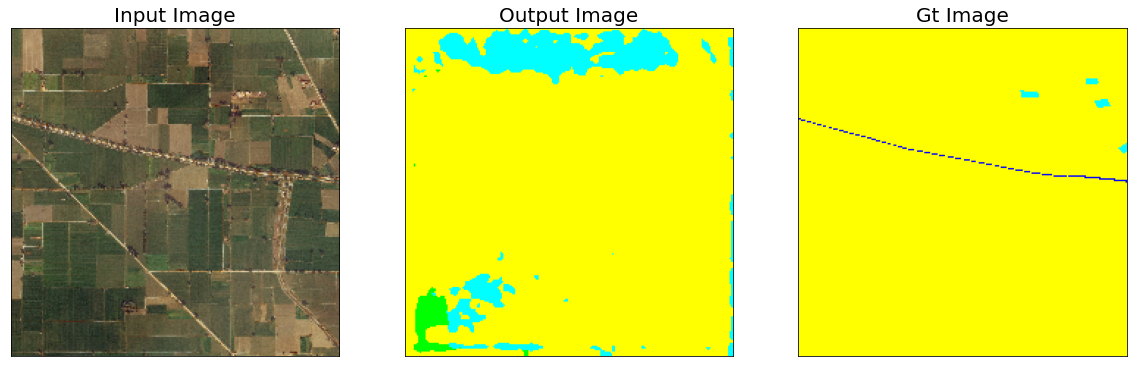

In [17]:
mask=load_img(term_project_dir+"data/land-train/" + "10233_mask.png", target_size=(224,224,3))
im=load_img(term_project_dir+"data/land-train/" + "10233_sat.jpg", target_size=(224,224,3))
im=np.expand_dims(im, axis=0)

# predict train data image 
output=deeplab.predict(im)
output=colour_code_segmentation(reverse_one_hot(np.squeeze(output)), select_class_rgb_values)
visualize(
    input_image=np.squeeze(im),
    output_image=output,
    gt_image=mask     
        )

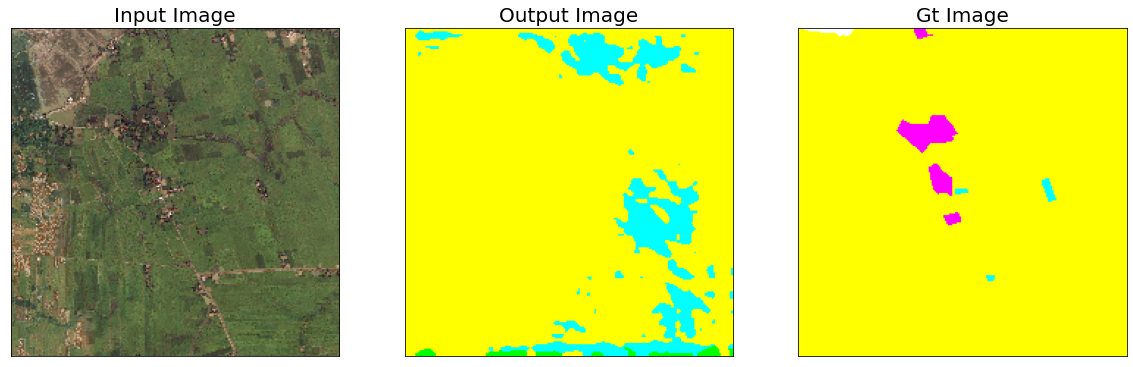

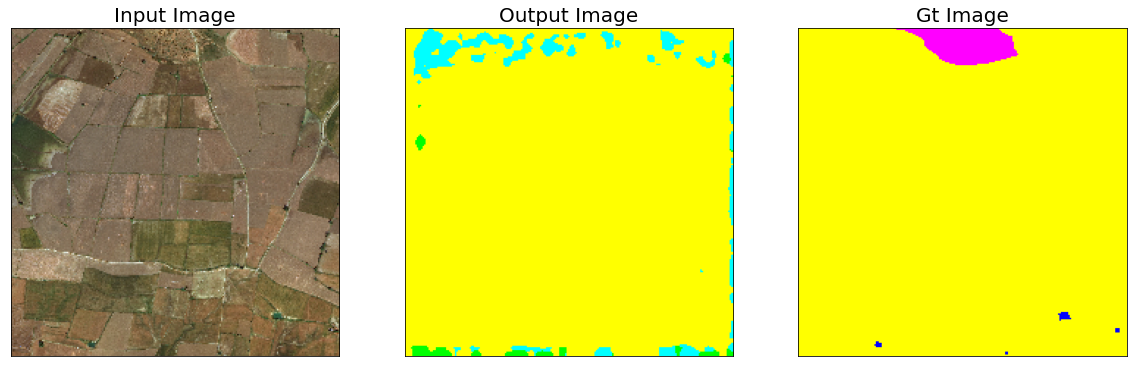

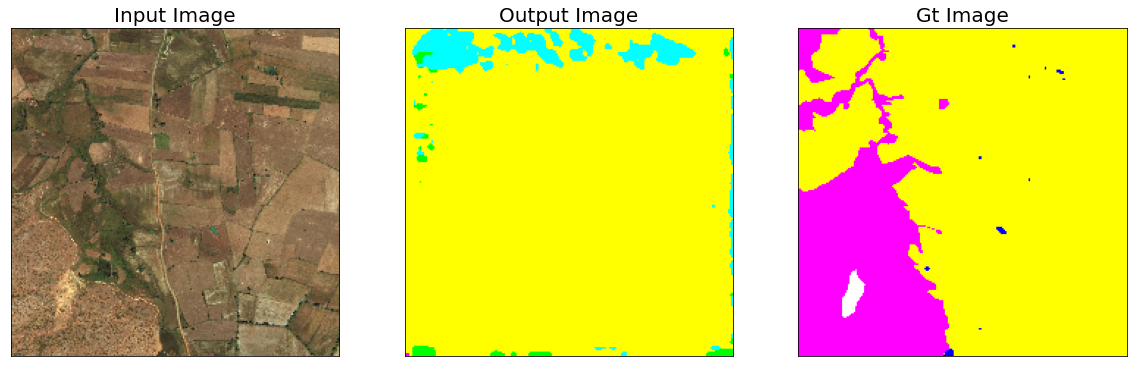

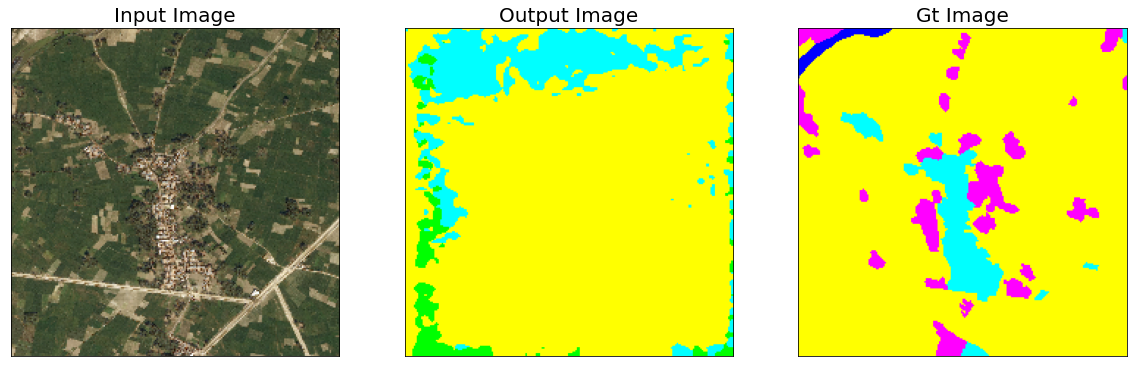

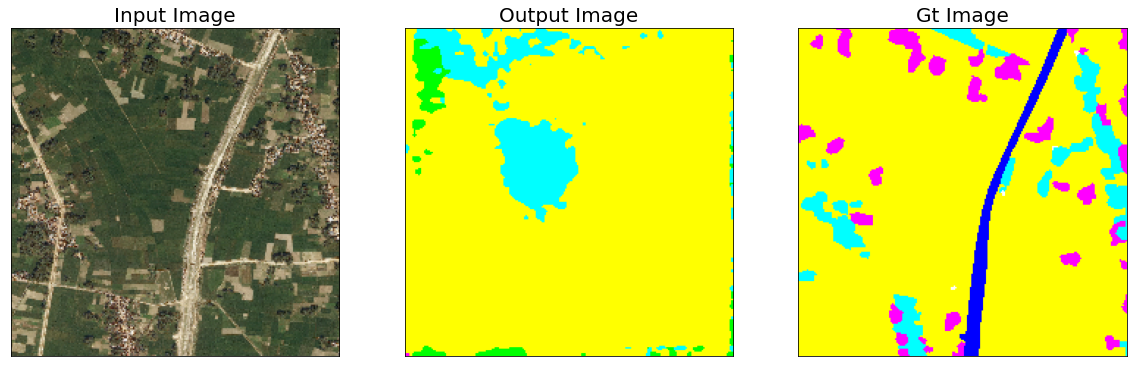

In [24]:
#sat_train_files
import glob
train_images=glob.glob(term_project_dir+'/data/land-train/*')
# load train images and their predictions
for i in np.random.choice(range(len(sat_train_files)), 5, replace=False):
    train_image=term_project_dir+'/data/land-train/'+sat_train_files[i]
    mask=load_img(term_project_dir+'/data/land-train/'+ mask_train_files[i], target_size=(224,224,3))
    im = load_img(train_image,target_size=(224,224,3))
    # predict
    im=np.expand_dims(im, axis=0)
    output=deeplab.predict(im)
    
    output=colour_code_segmentation(reverse_one_hot(np.squeeze(output)), select_class_rgb_values)

    # visualize prediction
    visualize(
        input_image=np.squeeze(im),
        output_image=np.squeeze(output),
        gt_image=mask     
            )

### Test sample

In [26]:
BATCH_SIZE = 32 
PATH_TEST =term_project_dir+'/data/land_test_sat/'
LEARNING_RATE = 0.001
INPUT_SIZE = (224, 224, 3)
CLASS = select_class_rgb_values

test_generator_augm = land_cover_DataGenerator(PATH_TRAIN,BATCH_SIZE,INPUT_SIZE, 
                                           class_rgb_values=CLASS, augmentation=True, augmentation_prob=0.1)
test_generator = land_cover_DataGenerator(PATH_VALIDATION,BATCH_SIZE,INPUT_SIZE, class_rgb_values=CLASS, 
                                                augmentation=False)

In [27]:
# show addtional evaluation metrics
deeplab.compile(loss=dice_loss,optimizer=opt,metrics=["Recall", "Precision", "categorical_accuracy", iou])

In [28]:
test_scores_deeplab=deeplab.evaluate(test_generator_augm)
print("Dice Loss: ", test_scores_deeplab[0])
print("Precision: ", test_scores_deeplab[1])
print("Recall: ", test_scores_deeplab[2])
print("Categorical Accuracy: ", test_scores_deeplab[3])
print("IoU: ", test_scores_deeplab[4])

2022-04-01 20:42:50.743571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 109s 4s/step - loss: 0.7360 - recall: 0.2420 - precision: 0.5887 - categorical_accuracy: 0.5789 - iou: 0.1521
Dice Loss:  0.7360075116157532
Precision:  0.2420450747013092
Recall:  0.588726818561554
Categorical Accuracy:  0.5788512229919434
IoU:  0.1520960032939911


2022-04-01 20:54:15.742595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


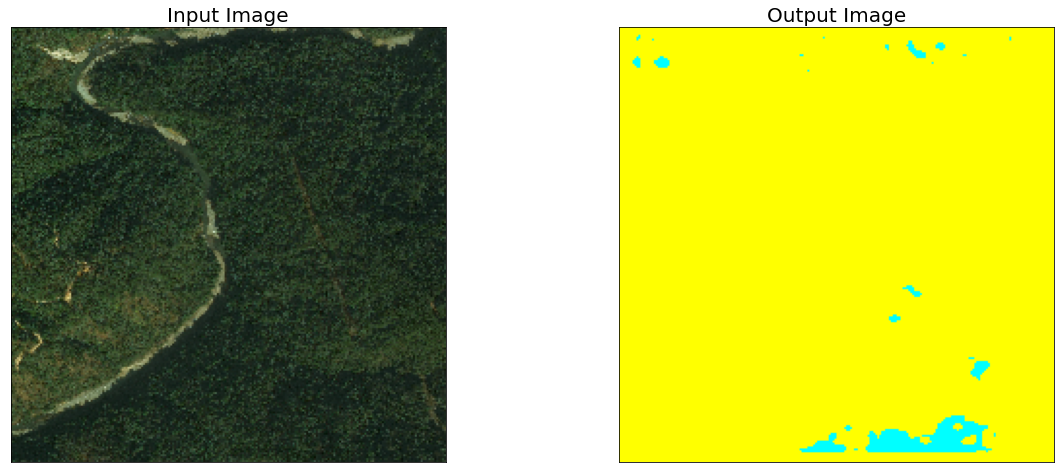

In [30]:
# Show prediction in action
im=load_img(term_project_dir+"data/land_test_sat/" + "6390_sat.jpg", target_size=(224,224,3))
im=np.expand_dims(im, axis=0)
output=deeplab.predict(im)
output=colour_code_segmentation(reverse_one_hot(np.squeeze(output)), select_class_rgb_values)
visualize(
    input_image=np.squeeze(im),
    output_image=output #,
    # gt_image=mask     
        )

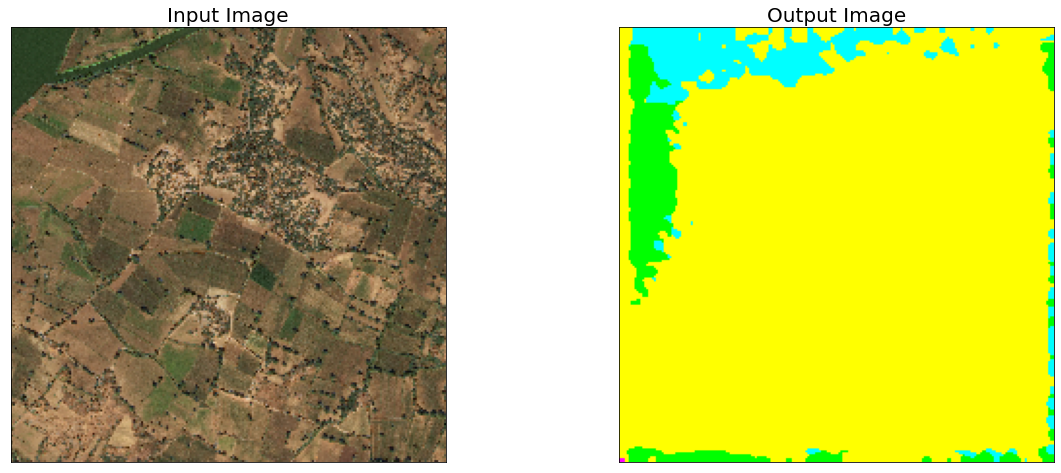

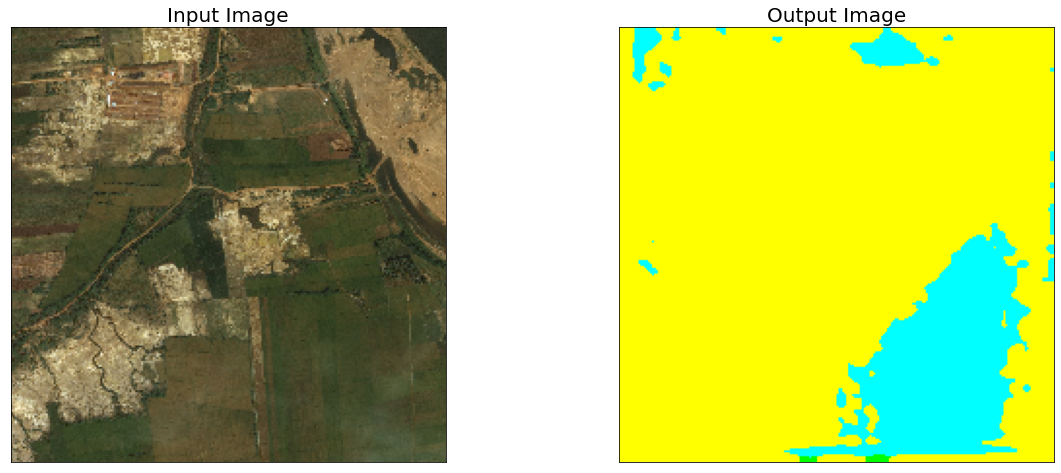

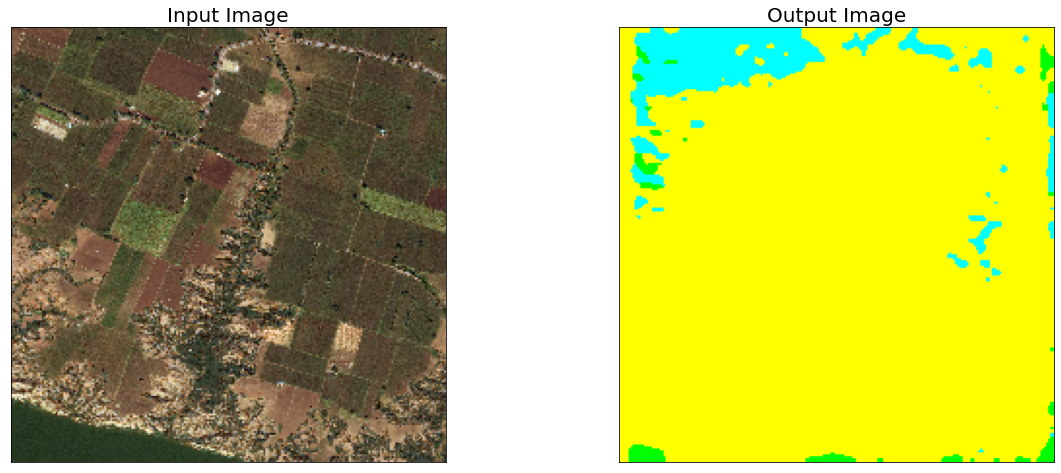

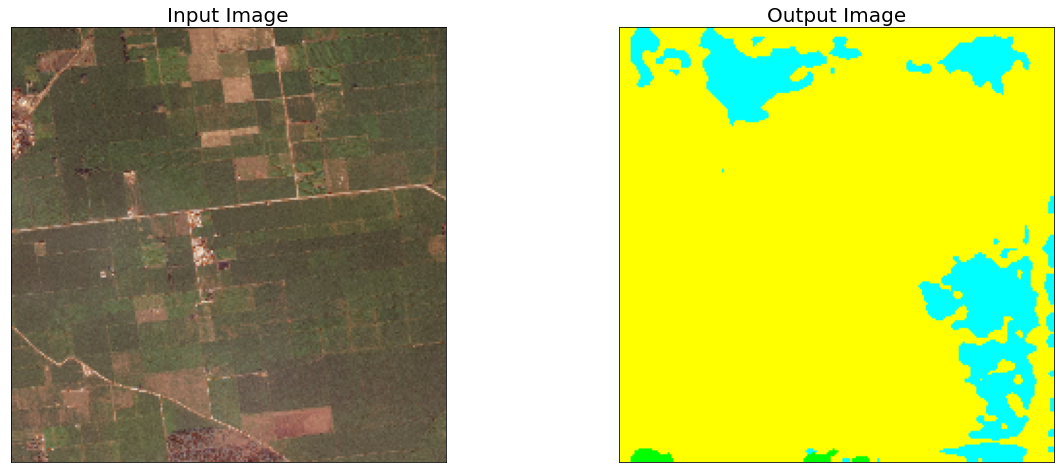

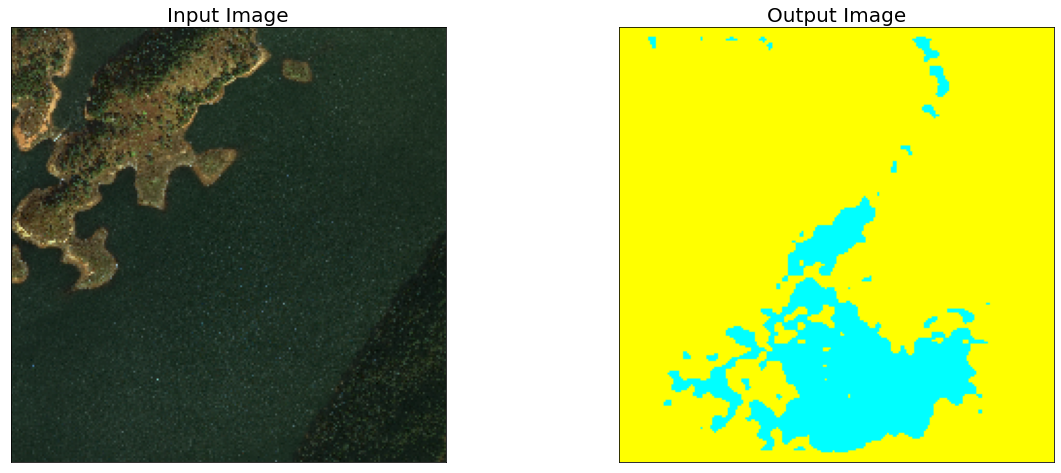

In [36]:
import glob
test_images=glob.glob(term_project_dir+'/data/land_test_sat/*')

# load test images and their predictions
for i in np.random.choice(range(len(test_images)), 5, replace=False):
    im = load_img(test_images[i],target_size=(224,224,3))
    # predict
    im=np.expand_dims(im, axis=0)
    output=deeplab.predict(im)
    
    output=colour_code_segmentation(reverse_one_hot(np.squeeze(output)), select_class_rgb_values)

    # visualize prediction
    visualize(
        input_image=np.squeeze(im),
        output_image=np.squeeze(output) #,
        # gt_image=mask     
            )

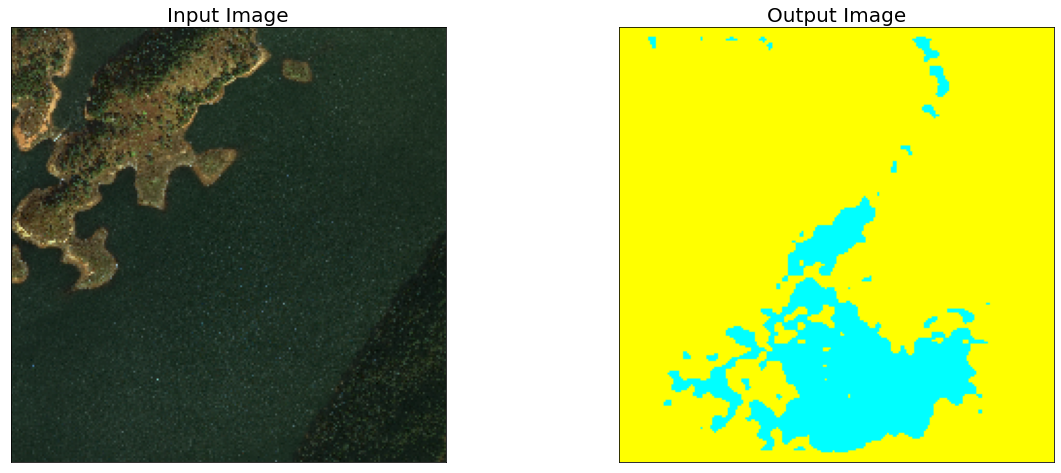

In [38]:
# show the prediction for the same image for the three models
image='/Users/pazma/Documents/BSE/spatial_data/term_project//data/land_test_sat/926551_sat.jpg'
im = load_img(image,target_size=(224,224,3))
    
# predict
im=np.expand_dims(im, axis=0)
output=deeplab.predict(im)
output=colour_code_segmentation(reverse_one_hot(output), select_class_rgb_values)

# visualize prediction
visualize(
    input_image=np.squeeze(im),
    output_image=np.squeeze(output) #,
    # gt_image=mask     
        )